In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Read Data

In [ ]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)

In [ ]:
prices = data.history(start='2014-01-01', end='2024-01-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

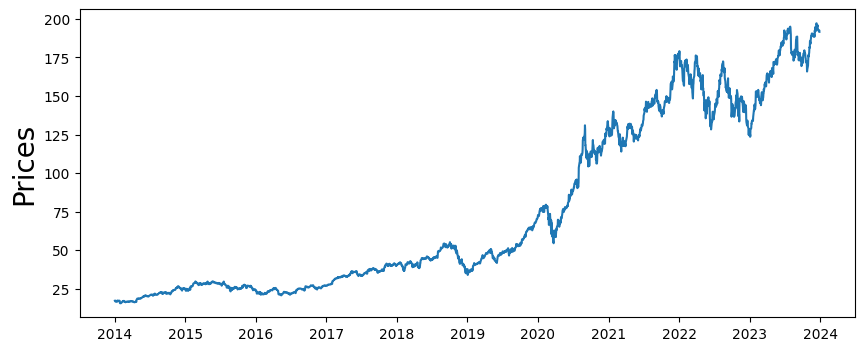

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

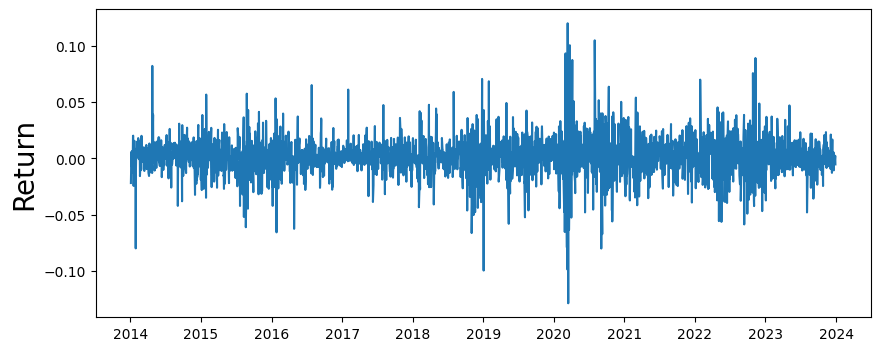

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

Text(0, 0.5, 'Return MA 90')

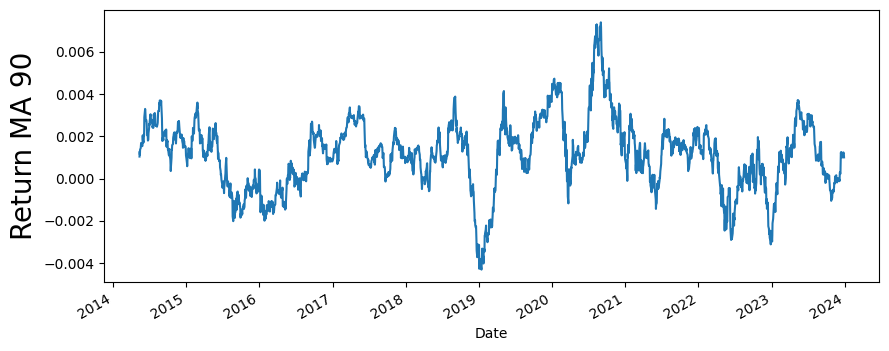

In [ ]:
returns.rolling(90).mean().dropna().plot(figsize=(10,4))
plt.ylabel('Return MA 90', fontsize=20)

Text(0, 0.5, 'Rolling STD 90')

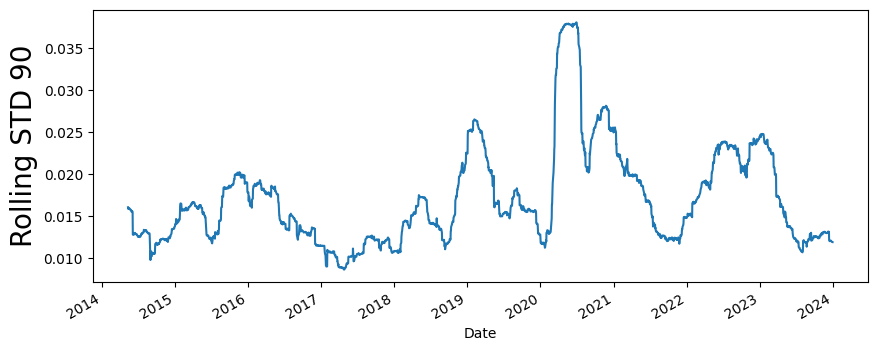

In [ ]:
returns.rolling(90).std().dropna().plot(figsize=(10,4))
plt.ylabel('Rolling STD 90', fontsize=20)

In [ ]:
prices = prices['2019-01-01':]
returns = returns['2019-01-01':]

Text(0, 0.5, 'Prices')

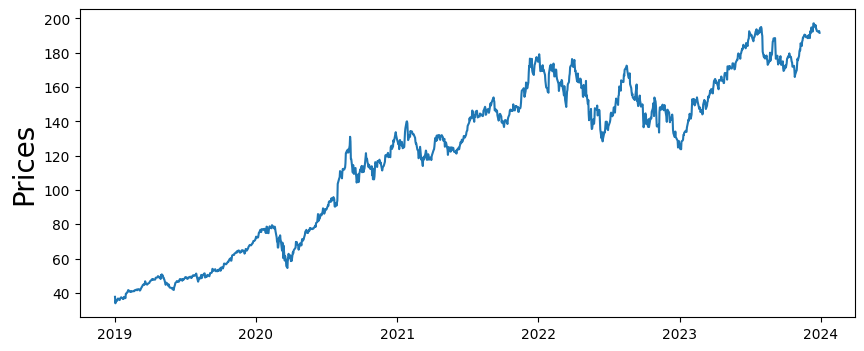

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

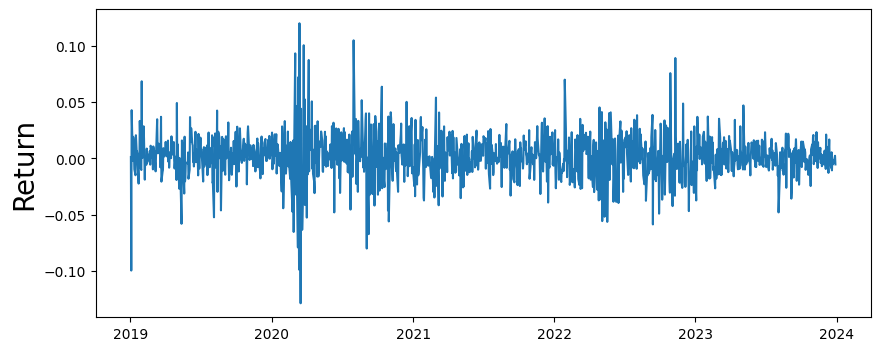

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

Text(0, 0.5, 'Return MA 90')

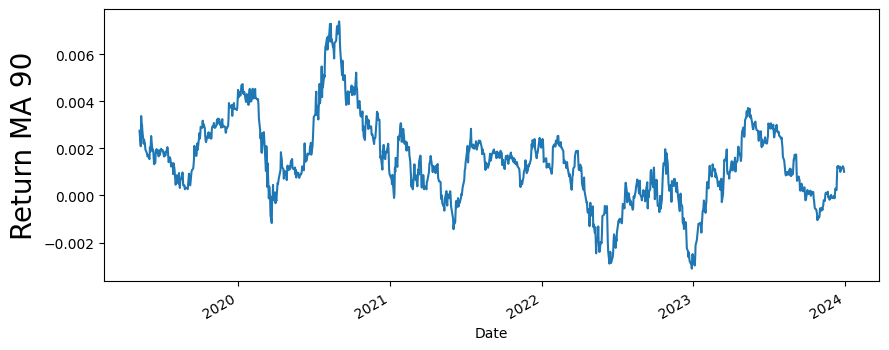

In [ ]:
returns.rolling(90).mean().dropna().plot(figsize=(10,4))
plt.ylabel('Return MA 90', fontsize=20)

Text(0, 0.5, 'Return Rolling STD 90')

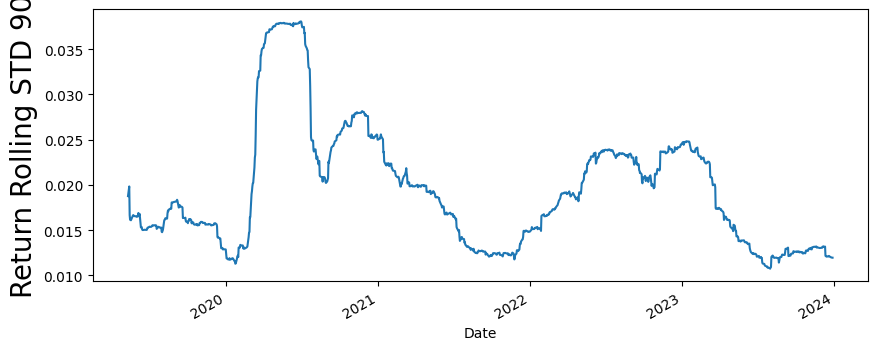

In [ ]:
returns.rolling(90).std().dropna().plot(figsize=(10,4))
plt.ylabel('Return Rolling STD 90', fontsize=20)

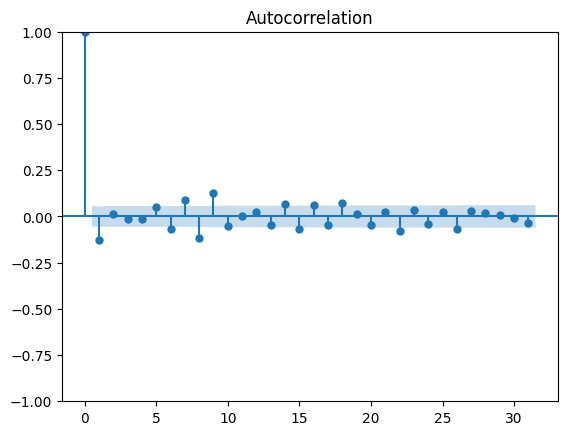

In [ ]:
plot_acf(returns)
plt.show()

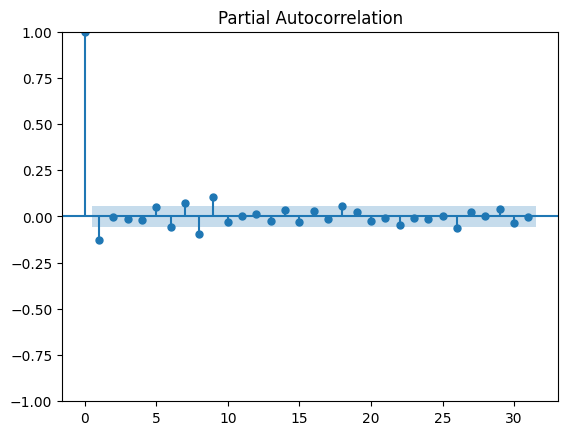

In [ ]:
plot_pacf(returns)
plt.show()

# Simulate Buying and Selling Stocks using ARIMA

In [ ]:
def plot_simulation(prices, events_list, thresh, amt, init_amt, predictions=None, test_returns=None):
    plt.figure(figsize=(10,4))
    plt.plot(prices)

    y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
    shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

    for idx, event in enumerate(events_list):
        plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
        if event[0] == 's':
            color = 'green' if event[2] > 0 else 'red'
            plt.fill_betweenx(range(*shaded_y_lims),
                              event[1], events_list[idx-1][1], color=color, alpha=0.1)

    tot_return = round(100*(amt / init_amt - 1), 2)
    tot_return = str(tot_return) + '%'

    title = f'{tickerSymbol} Price Data\nThresh={thresh}, Total Amt: {round(amt,2)}$, Total Return: {tot_return}'

    if predictions is not None:
        rmse = round(np.sqrt(mean_squared_error(predictions, test_returns)), 4)
        title += f', RMSE: {rmse}'

    plt.title(title)
    plt.ylim(*y_lims)
    plt.show()

In [ ]:
def run_simulation(returns, prices, amt, order, start_date, trend='c', thresh=0, verbose=False, plot=True):
    if type(order) == float:
        thresh = None

    curr_holding = False
    events_list = []
    init_amt = amt
    test_prices = prices.loc[start_date:]
    test_returns = []
    return_preds = []

    #go through dates
    for date, _ in tqdm(test_prices.items(), total=len(test_prices)):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = test_prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date].reset_index(drop=True)

        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order, trend=trend).fit()
                #get forecast
                pred = model.forecast().iloc[0]
                return_preds.append(pred)
                test_returns.append(returns[date])
            except Exception as e:
                print('EXCEPTION:', e)
                pred = thresh - 1
                return_preds.append(None)
        if order == 'random':
            pred = np.random.random() - 0.5
        elif order == 'last':
            pred = curr_data.iloc[-1]

        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and pred > thresh:
            curr_holding = True
            buy_price = test_prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)

    if verbose:
        print('Total Amount: $%s'%round(amt,2))

    #graph
    if plot:
      plot_simulation(test_prices, events_list, thresh, amt, init_amt,
                      predictions=return_preds if type(order) == tuple else None,
                      test_returns=test_returns if type(order) == tuple else None)


    return amt

# Baseline Model : Random Buying

100%|██████████| 250/250 [00:00<00:00, 6816.59it/s]


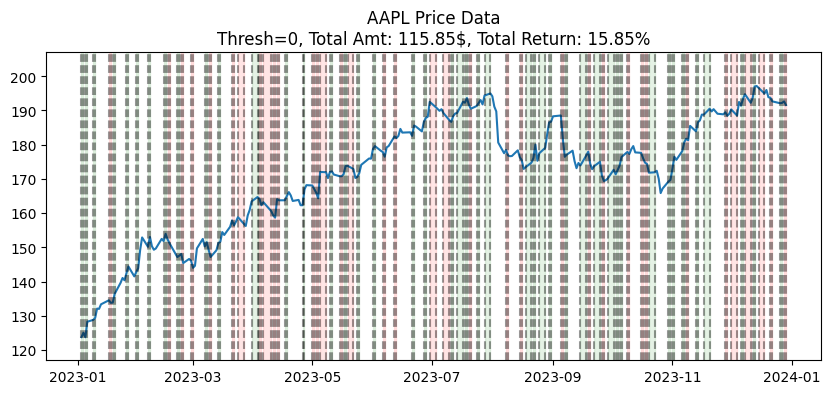

115.84796462351859

In [ ]:
run_simulation(returns, prices, 100, 'random', '2023-01-01', verbose=False)

In [ ]:
final_amts = [run_simulation(returns, prices, 100, 'random', '2023-01-01', verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 250/250 [00:00<00:00, 4628.58it/s]


Text(0.5, 1.0, 'Avg: $116.4\nSD: $10.11')

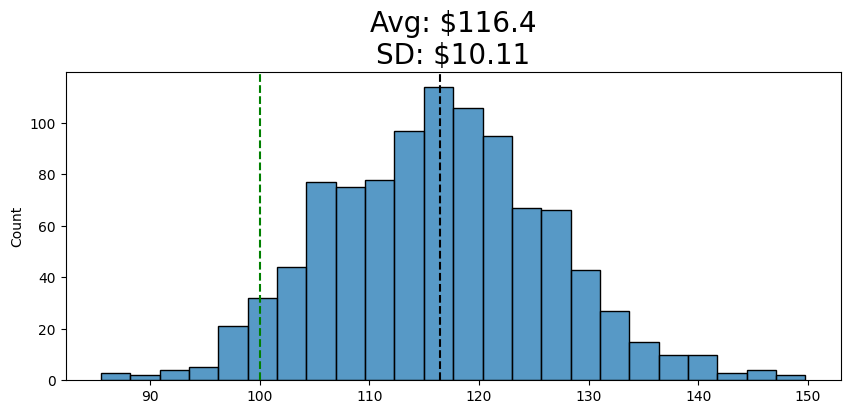

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If Last Return was Positive, Buy

100%|██████████| 250/250 [00:00<00:00, 6287.90it/s]


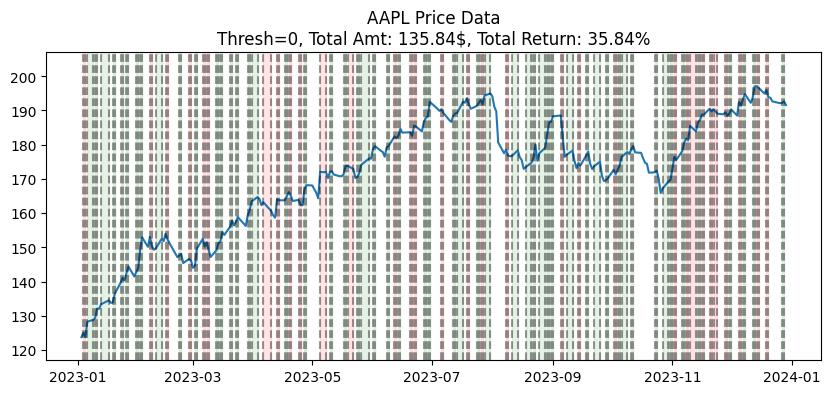

135.8388823893775

In [ ]:
run_simulation(returns, prices, 100, 'last', '2023-01-01', verbose=False)

# Buy and Hold

In [ ]:
test_prices = prices['2023-01-01':]
print(f'Return on Buy and Hold: {round(100 * (test_prices.iloc[-1] - test_prices.iloc[0]) / test_prices.iloc[0], 2)}%')

Return on Buy and Hold: 54.8%


# AR Models


ORDER: (1, 0, 0)


100%|██████████| 250/250 [00:46<00:00,  5.38it/s]


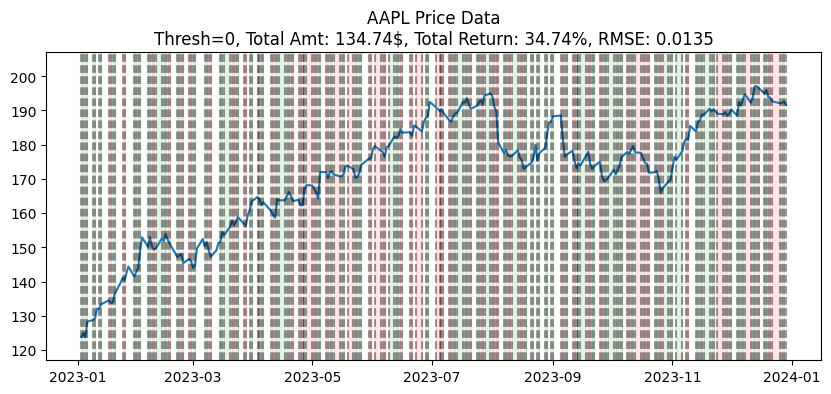


ORDER: (3, 0, 0)


100%|██████████| 250/250 [00:57<00:00,  4.34it/s]


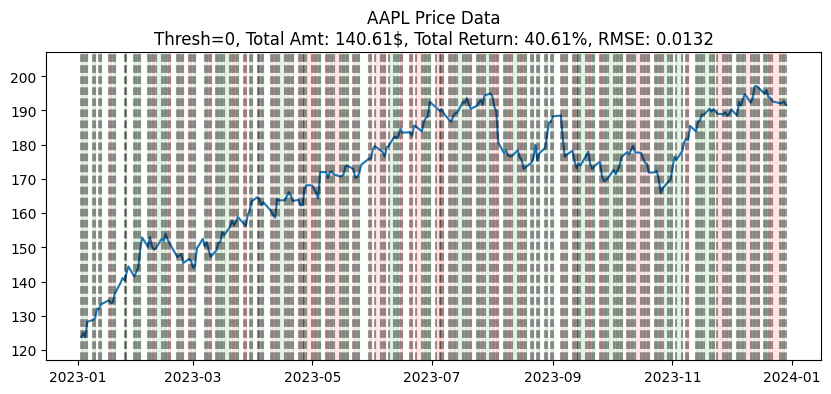


ORDER: (5, 0, 0)


100%|██████████| 250/250 [01:53<00:00,  2.21it/s]


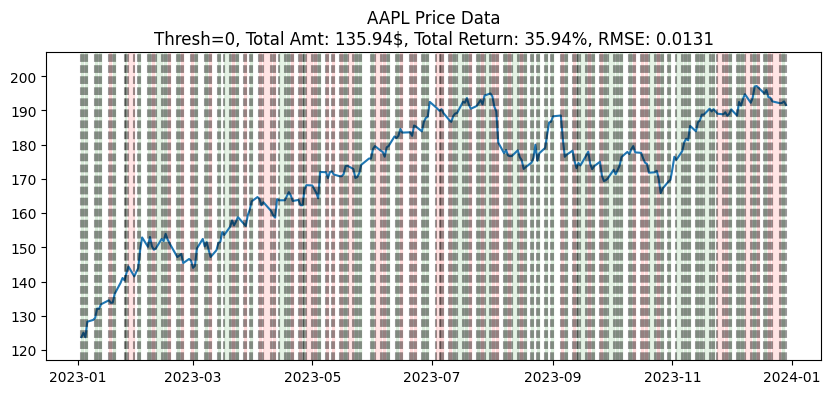


ORDER: (7, 0, 0)


100%|██████████| 250/250 [02:46<00:00,  1.51it/s]


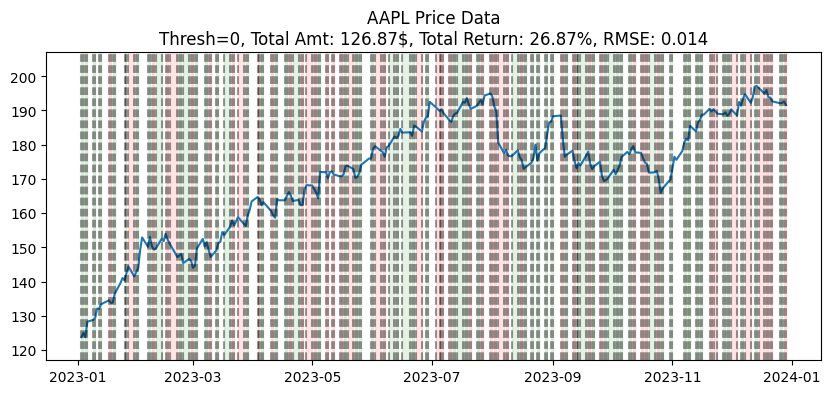


ORDER: (9, 0, 0)


100%|██████████| 250/250 [03:44<00:00,  1.11it/s]


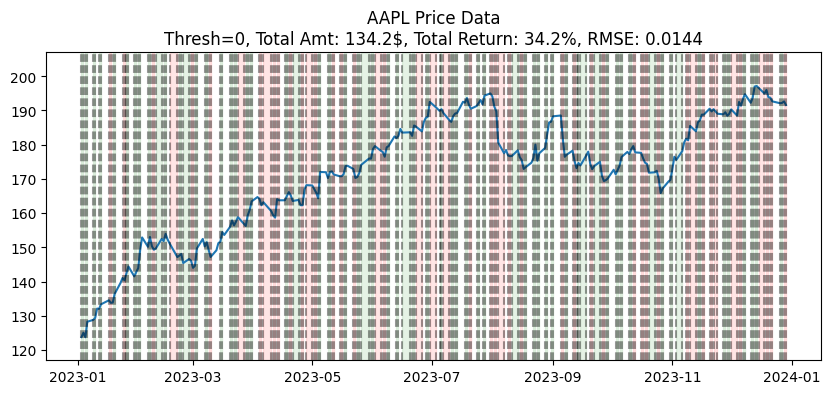

In [ ]:
orders = [(1,0,0), (3,0,0), (5,0,0), (7,0,0), (9,0,0)]
for order in orders:
    print('\nORDER:', order)
    run_simulation(returns, prices, 100, order, '2023-01-01', verbose=False)

# ARMA Models

100%|██████████| 250/250 [01:15<00:00,  3.31it/s]


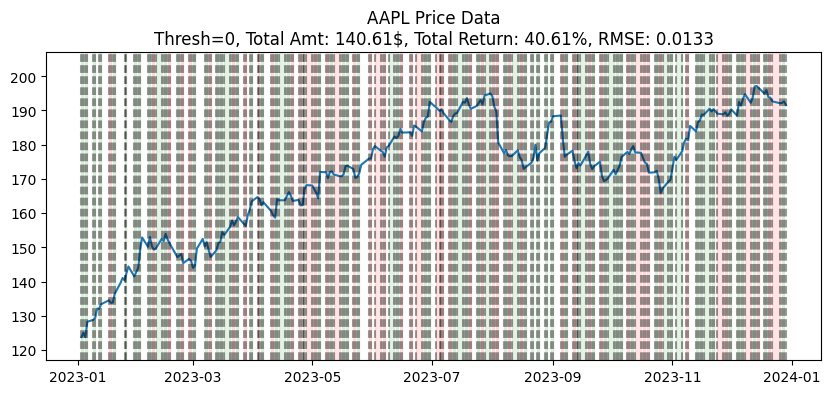

140.60755093484602

In [ ]:
run_simulation(returns, prices, 100, (3,0,1), '2023-01-01', verbose=False)

100%|██████████| 250/250 [01:55<00:00,  2.16it/s]


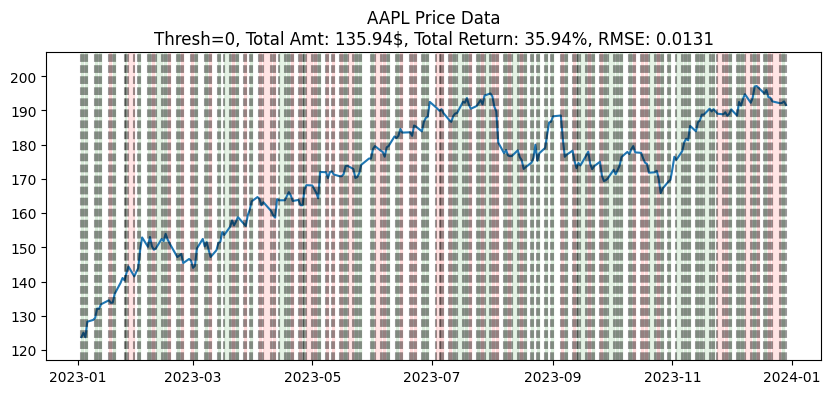

135.94156767426517

In [ ]:
run_simulation(returns, prices, 100, (5,0,1), '2023-01-01', verbose=False)